In [1]:
from lazypredict.Supervised import LazyClassifier

In [2]:
import datasets
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd

In [4]:
from pathlib import Path
from glob import glob

In [5]:
participants = [Path(path).stem for path in glob('./data/ecg_features_60s/*.csv')]
train_participants, test_participants = train_test_split(participants, test_size=0.2)
# train_participants, val_participants = train_test_split(train_participants, test_size=0.25)

In [6]:
dataset = load_dataset(
    './data/ecg_features_60s', 
    train_participants=train_participants,
    # val_participants=val_participants,
    test_participants=test_participants,
    trust_remote_code=True
)

Generating fit split: 3094291 examples [00:12, 257589.56 examples/s]
Generating test split: 778993 examples [00:03, 251459.71 examples/s]


In [7]:
baseline = ['Sitting', 'Recov1', 'Recov2', 'Recov3', 'Recov4', 'Recov5', 'Recov6']
mental_stress = ['TA', 'SSST_Sing_countdown', 'Pasat', 'Raven', 'TA_repeat', 'Pasat_repeat']
high_physical_stress = ['Treadmill1', 'Treadmill2', 'Treadmill3', 'Treadmill4', 'Walking_fast_pace', 'Cycling', 'stairs_up_and_down']
moderate_physical_stress = ['Walking_own_pace', 'Dishes', 'Vacuum']
low_physical_stress = ['Standing', 'Lying_supine', 'Recov_standing']

#### Multiclass

In [8]:
dataset['fit'] = dataset['fit'].filter(lambda x: x['label'] != None)
dataset['test'] = dataset['test'].filter(lambda x: x['label'] != None)

Filter: 100%|██████████| 778993/778993 [00:08<00:00, 92307.47 examples/s]


In [9]:
def encode(samples):
    baseline = ['Sitting', 'Recov1', 'Recov2', 'Recov3', 'Recov4', 'Recov5', 'Recov6']
    mental_stress = ['TA', 'SSST_Sing_countdown', 'Pasat', 'Raven', 'TA_repeat', 'Pasat_repeat']
    high_physical_stress = ['Treadmill1', 'Treadmill2', 'Treadmill3', 'Treadmill4', 'Walking_fast_pace', 'Cycling', 'stairs_up_and_down']
    moderate_physical_stress = ['Walking_own_pace', 'Dishes', 'Vacuum']
    low_physical_stress = ['Standing', 'Lying_supine', 'Recov_standing']
    
    def encode_multiclass(label):
        if label in baseline:
            return 0
        elif label in mental_stress:
            return 1
        elif label in high_physical_stress:
            return -1
        elif label in moderate_physical_stress:
            return -1
        elif label in low_physical_stress:
            return -1
        else:
            return -1
        
    return {
        'label': [encode_multiclass(label) for label in samples['label']],
    }

In [10]:
dataset['fit'] = dataset['fit'].map(encode, batched=True, batch_size=2048, num_proc=4)
dataset['test'] = dataset['test'].map(encode, batched=True, batch_size=2048, num_proc=4)

Map (num_proc=4): 100%|██████████| 733174/733174 [00:22<00:00, 33250.62 examples/s]


In [11]:
dataset['fit'].to_pandas()['label'].value_counts()

label
-1    1120211
 1     948160
 0     825657
Name: count, dtype: int64

#### Boolean

In [123]:
def encode(samples):
    baseline = ['Sitting', 'Recov1', 'Recov2', 'Recov3', 'Recov4', 'Recov5', 'Recov6']
    mental_stress = ['TA', 'SSST_Sing_countdown', 'Pasat', 'Raven', 'TA_repeat', 'Pasat_repeat']
    high_physical_stress = ['Treadmill1', 'Treadmill2', 'Treadmill3', 'Treadmill4', 'Walking_fast_pace', 'Cycling', 'stairs_up_and_down']
    moderate_physical_stress = ['Walking_own_pace', 'Dishes', 'Vacuum']
    low_physical_stress = ['Standing', 'Lying_supine', 'Recov_standing']
    
    def encode_boolean(label):
        if isinstance(label, int):
            return label
        elif label in baseline:
            return 0
        elif label in mental_stress:
            return -1
        elif label in high_physical_stress:
            return 1
        elif label in moderate_physical_stress:
            return -1
        elif label in low_physical_stress:
            return -1
        else:
            return -1
        
    return {
        'label': [encode_boolean(label) for label in samples['label']],
    }

In [124]:
dataset['fit'] = dataset['fit'].map(encode, batched=True, batch_size=2048, num_proc=4)
dataset['test'] = dataset['test'].map(encode, batched=True, batch_size=2048, num_proc=4)

Map (num_proc=4): 100%|██████████| 730064/730064 [00:03<00:00, 216499.72 examples/s]


In [12]:
dataset['fit'].to_pandas()['label'].value_counts()

label
-1    1120211
 1     948160
 0     825657
Name: count, dtype: int64

In [13]:
X_labels =  [
    'μhrv',
    'σhrv',
    'TINN',
    'rmsHRV',
    'ULF',
    'LF',
    'HF',
    'UHF',
    'LF_HF_ratio',
    'Σ',
    'relative_power_ulf',
    'relative_power_lf',
    'relative_power_hf',
    'relative_power_uhf',
    'LF_norm',
    'HF_norm'
]
# X_labels = [
#     'μhr',
#     'σhr',
#     'hr_max',
#     'hr_min',
#     'NN50',
#     'pNN50',
#     'rmssd',
#     'rr_mean',
#     'rr_std',
#     'UHF',
#     'LF_HF_ratio',
# ]
y_label = 'label'

In [14]:
train = dataset['fit'].to_pandas()
test = dataset['test'].to_pandas()

In [15]:
train = train.drop(train[train['label'] == -1].index)
test = test.drop(test[test['label'] == -1].index)

In [16]:
train['label'].value_counts()

label
1    948160
0    825657
Name: count, dtype: int64

In [17]:
import numpy as np

In [18]:
train.replace([np.inf, -np.inf], 0, inplace=True)
test.replace([np.inf, -np.inf], 0, inplace=True)

In [19]:
X_train = train[X_labels]
y_train = train[y_label]

X_test = test[X_labels]
y_test = test[y_label]

In [133]:
# clf = LazyClassifier(verbose= 0, ignore_warnings= True, custom_metric= None)

In [134]:
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [136]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [137]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.5231020842008371
Balanced Accuracy: 0.530205917908407
F1 Score: 0.5197257902787717


In [20]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.5574360604001841
Balanced Accuracy: 0.5622941973306812
F1 Score: 0.5493617375982633


In [24]:
clf.feature_importances_

array([0.1084318 , 0.10952973, 0.12088476, 0.10993704, 0.02478981,
       0.06333886, 0.04121367, 0.05280126, 0.05682081, 0.02824623,
       0.05250577, 0.06281654, 0.03904987, 0.05315293, 0.03855746,
       0.03792346])

In [150]:
from sklearn.ensemble import AdaBoostClassifier

In [151]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', min_samples_split=20), n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [152]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.557420993227991
Balanced Accuracy: 0.5621505763721649
F1 Score: 0.5494224999102746


In [153]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [139]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [140]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.5342148085647286
Balanced Accuracy: 0.5131638078860119
F1 Score: 0.4894099083747585


In [141]:
from sklearn.neighbors import KNeighborsClassifier

In [142]:
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [143]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.49719476648622585
Balanced Accuracy: 0.5084185667681679
F1 Score: 0.4940319596151195


In [144]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV 

models = {
    'LR': Pipeline([('scaler', StandardScaler()),  ('log_reg', LogisticRegression())]),
    'XGB': Pipeline([('scaler', StandardScaler()),  ('XGB', XGBClassifier())]),
    'QDA': Pipeline([('scaler', StandardScaler()),  ('QDA', QuadraticDiscriminantAnalysis())])
}

parameters = {
    'LR': {
        'log_reg__penalty': ['l2'],
        'log_reg__C': [10, 5, 3, 1],
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
    },
    'RF': {
        'RF__max_depth': [2, 5, 8], 
        'RF__n_estimators': [100, 500, 800],
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
    },
    'XGB': {
        'XGB__max_depth': [2, 5, 8],
        'XGB__n_estimators': [100, 500, 800],
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
    },
    'LDA': {
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
        
    },
    'QDA': {
#         'pca__n_components': [5, 20, 30, 40, 50, 64]
    }
}
durations = {
    'LR': 0,
    'RF': 0,
    'XGB': 0,
    'LDA': 0,
    'QDA': 0
}
labels_proba = {
    'LR_tr': 0,
    'LR_te': 0,
    'RF_tr': 0,
    'RF_te': 0,
    'XGB_tr': 0,
    'XGB_te': 0,
    'LDA_tr': 0,
    'LDA_te': 0,
    'QDA_tr': 0,
    'QDA_te': 0
}
labels_predict = {
    'LR_tr': 0,
    'LR_te': 0,
    'RF_tr': 0,
    'RF_te': 0,
    'XGB_tr': 0,
    'XGB_te': 0,
    'LDA_tr': 0,
    'LDA_te': 0,
    'QDA_tr': 0,
    'QDA_te': 0
}

In [145]:
#Stratified KFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [146]:
import warnings 

for model_name in models.keys():
    print('Fit ' + model_name)
    warnings.simplefilter(action='ignore')
    clf = GridSearchCV(models[model_name], parameters[model_name],
                       cv=cv, n_jobs=-1,scoring = 'f1')
    clf.fit(X_train, y_train)
    print ('For {} best estimator = {} \nbest params = {}'.format(model_name, clf.best_estimator_, clf.best_params_))
    # Predition part
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    # labels_proba[model_name + '_te'] = y_prob
    # labels_predict[model_name + '_te'] = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", model_name, accuracy)
    print("Balanced Accuracy:", model_name, balanced_accuracy)
    print("F1 Score:", model_name, f1)

Fit LR
For LR best estimator = Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(C=10))]) 
best params = {'log_reg__C': 10, 'log_reg__penalty': 'l2'}
Accuracy: LR 0.5268195665037586
Balanced Accuracy: LR 0.5202673570463626
F1 Score: LR 0.4880325605319916
Fit XGB
For XGB best estimator = Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                           

# https://dl-acm-org.vu-nl.idm.oclc.org/doi/epdf/10.1145/3242969.3242985

In [39]:
from sklearn import preprocessing

In [40]:
lf_scaler = preprocessing.MinMaxScaler()
hf_scaler = preprocessing.MinMaxScaler()

In [41]:
train['LF_norm'] = lf_scaler.fit_transform(train[['lf']])
test['LF_norm'] = lf_scaler.fit_transform(test[['lf']])

In [42]:
train['HF_norm'] = lf_scaler.fit_transform(train[['hf']])
test['HF_norm'] = lf_scaler.fit_transform(test[['hf']])

In [43]:
X_labels = ['mean_hr', 'std_hr', 'mean_hrv', 'std_hrv', 'nn50', 'HRV_pNN50', 'HRV_TINN', 'rms_hrv', 'ulf', 'lf', 'hf', 'uhf', 'lf_hf_ratio', 'total_power', 'relative_power_ulf', 'relative_power_lf', 'relative_power_hf', 'relative_power_uhf', 'LF_norm', 'HF_norm'] 
y_label = 'label'

In [44]:
X_train = train[X_labels]
y_train = train[y_label]

X_test = test[X_labels]
y_test = test[y_label]

In [48]:
clf = LazyClassifier(verbose= 0, ignore_warnings= True, custom_metric= None)

In [ ]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [07:29<00:00, 15.51s/it]

[LightGBM] [Info] Number of positive: 11767, number of negative: 26813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3387
[LightGBM] [Info] Number of data points in the train set: 38580, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.305003 -> initscore=-0.823588
[LightGBM] [Info] Start training from score -0.823588


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.55,0.62,0.62,0.57,0.05
NearestCentroid,0.58,0.62,0.62,0.60,0.04
BernoulliNB,0.61,0.62,0.62,0.63,0.04
LabelSpreading,0.66,0.57,0.57,0.65,66.38
Perceptron,0.66,0.57,0.57,0.65,0.05
NuSVC,0.65,0.57,0.57,0.64,242.07
LabelPropagation,0.65,0.57,0.57,0.65,41.63
KNeighborsClassifier,0.66,0.57,0.57,0.65,0.36
XGBClassifier,0.69,0.56,0.56,0.66,0.21


# Test

In [82]:
import seaborn as sns

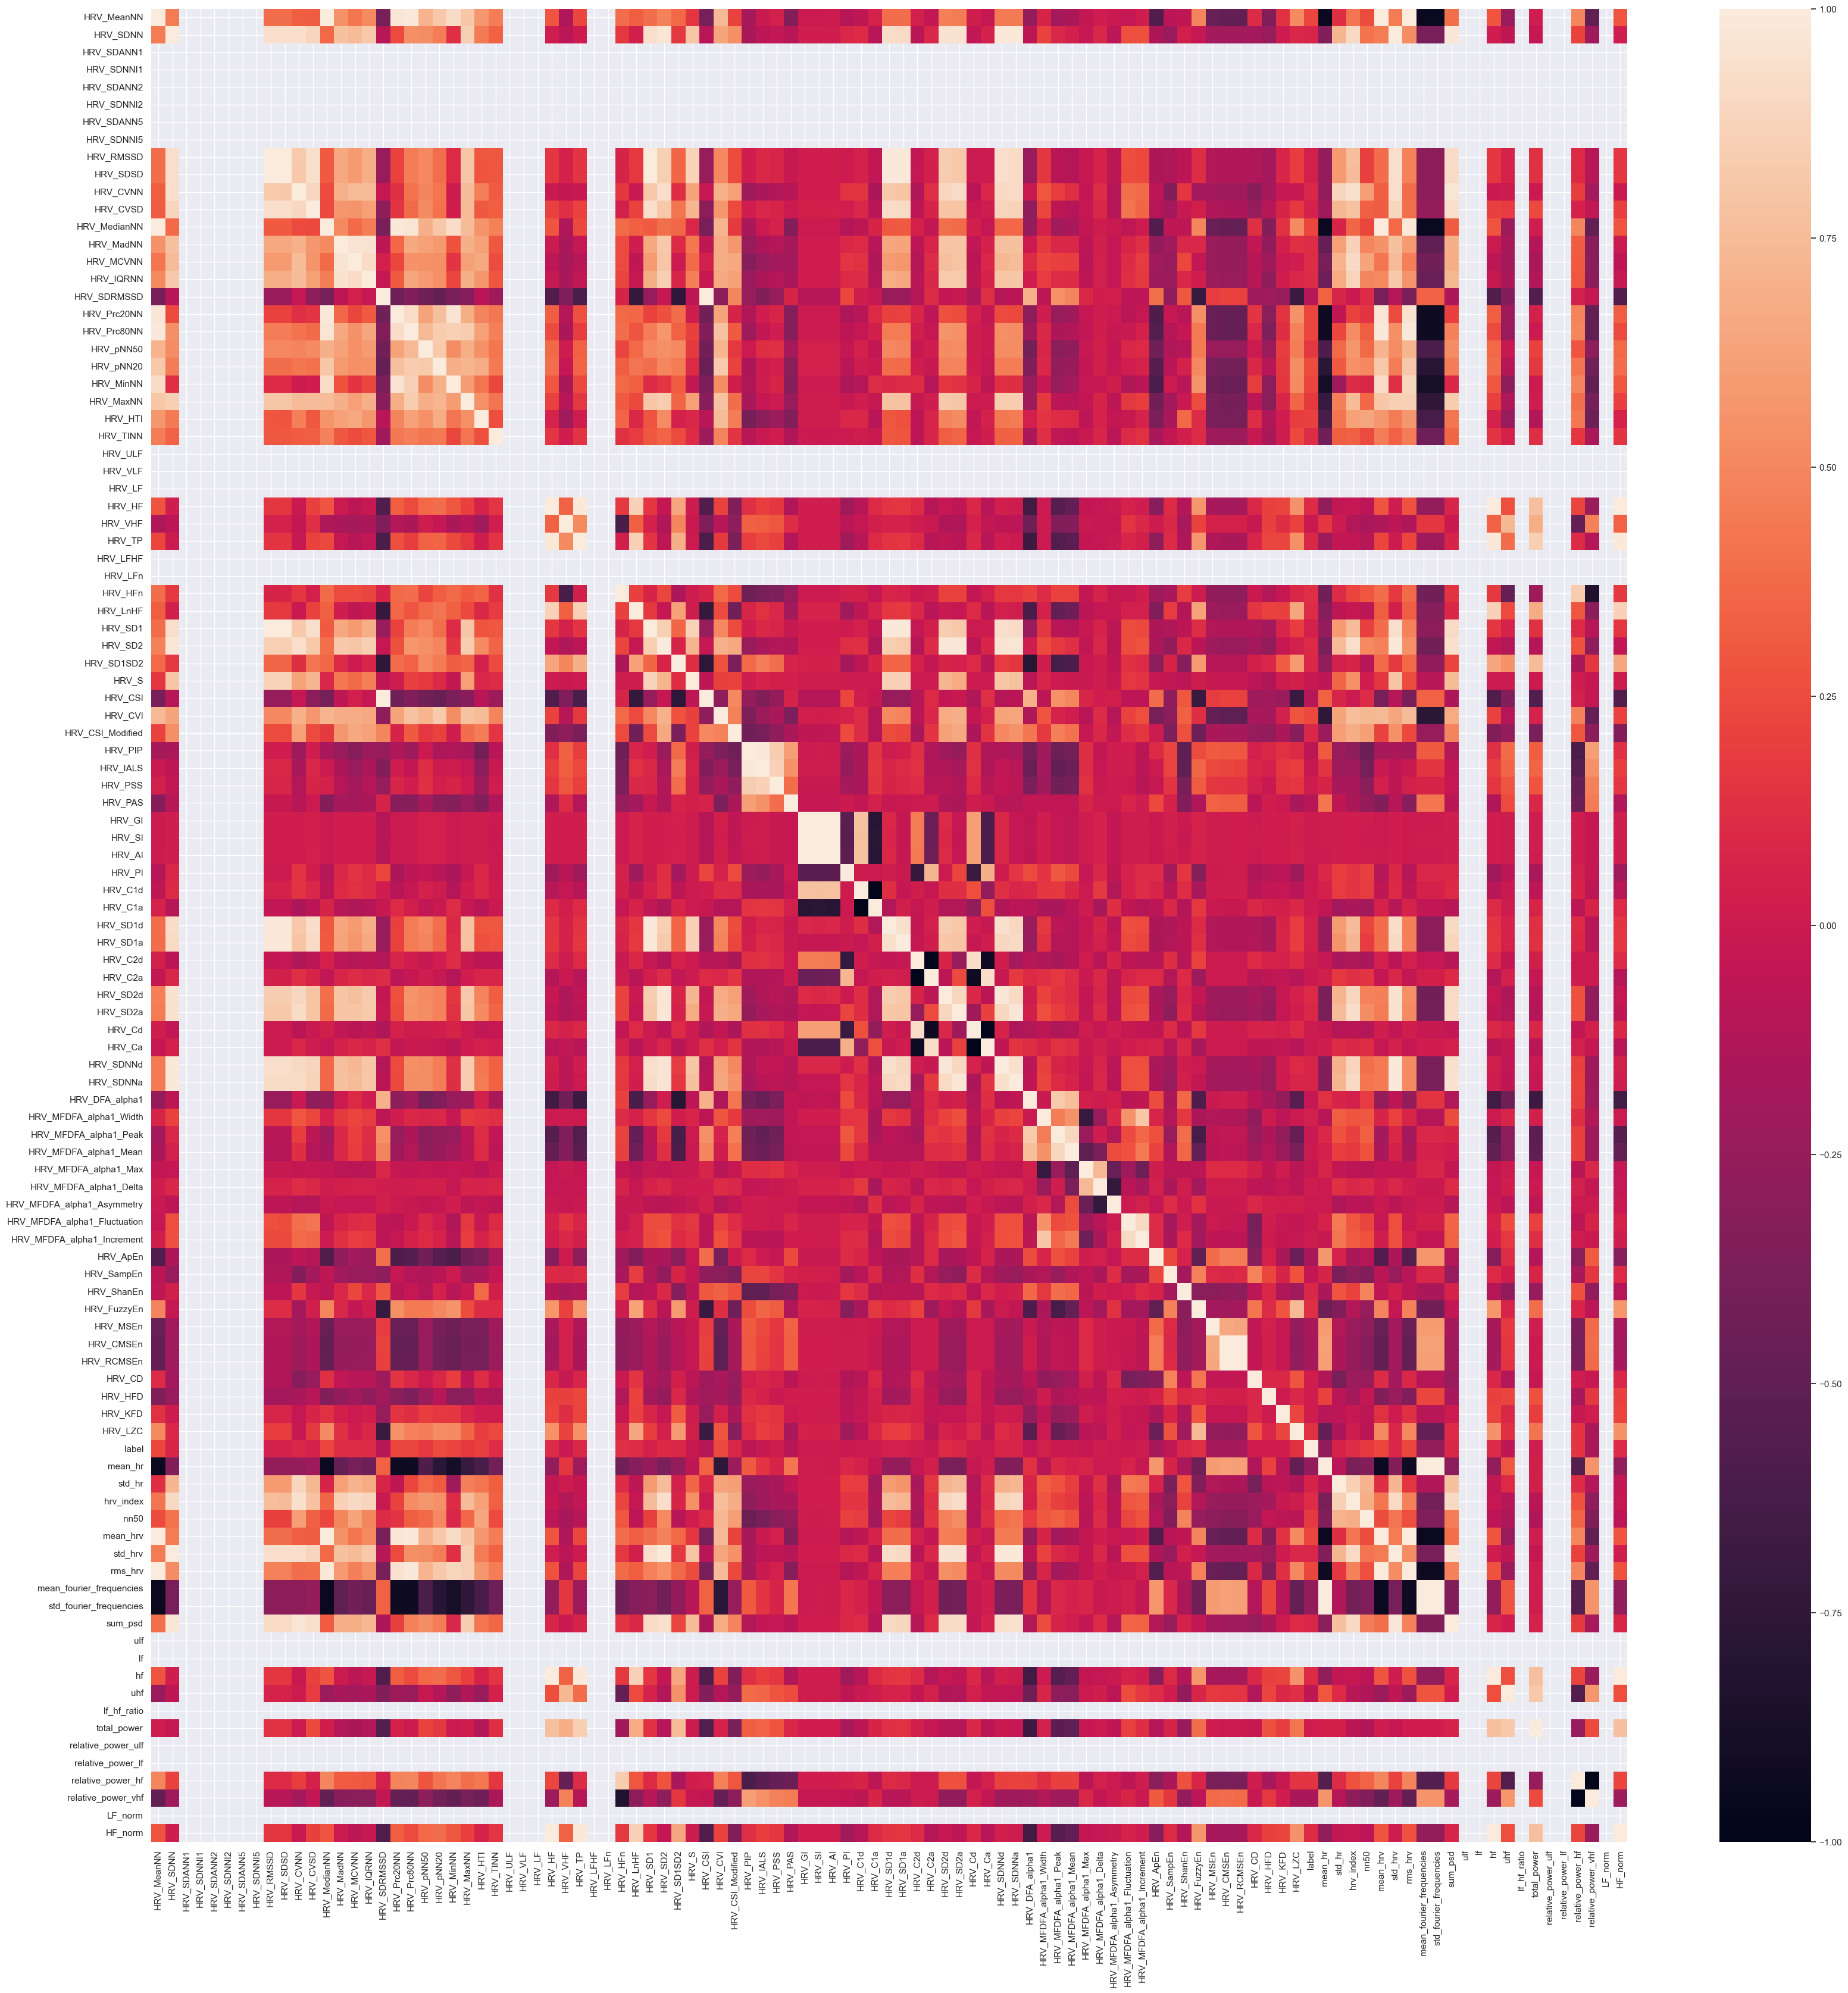

In [84]:
sns.set_theme(rc={'figure.figsize':(40,40)})
ax = sns.heatmap(
    train.corr(),
)

In [87]:

import pandas as pd
def top_corr(data: pd.DataFrame, column: str, n: int):
    corr_matrix = data.corr()
    corr_sorted = corr_matrix[column].sort_values(key=lambda x: -x)[1:n + 1]
    return pd.DataFrame({
        'Features': [column for _ in range(n)],
        'Top Similar Features': corr_sorted.index,
        'Correlation': corr_sorted.values
    })


In [93]:
df = top_corr(train, 'label', 10)

In [94]:
X_labels = df['Top Similar Features'].to_list()
y_label = 'label'

In [95]:
X_train = train[X_labels]
y_train = train[y_label]

X_test = test[X_labels]
y_test = test[y_label]

In [96]:
clf = LazyClassifier(verbose= 0, ignore_warnings= True, custom_metric= None)

In [97]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [04:39<00:00,  9.63s/it]

[LightGBM] [Info] Number of positive: 11767, number of negative: 26813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2471
[LightGBM] [Info] Number of data points in the train set: 38580, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.305003 -> initscore=-0.823588
[LightGBM] [Info] Start training from score -0.823588


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.59,0.65,0.65,0.61,0.03
BernoulliNB,0.59,0.64,0.64,0.61,0.03
NearestCentroid,0.59,0.63,0.63,0.61,0.02
QuadraticDiscriminantAnalysis,0.50,0.60,0.60,0.49,0.03
SGDClassifier,0.64,0.57,0.57,0.64,0.07
KNeighborsClassifier,0.65,0.55,0.55,0.63,0.33
DecisionTreeClassifier,0.61,0.55,0.55,0.62,0.87
NuSVC,0.58,0.55,0.55,0.59,94.92
ExtraTreeClassifier,0.61,0.55,0.55,0.61,0.07


## WESAD

In [5]:
participants = [Path(path).stem for path in glob('./data/wesad_features_60s/*.csv')]
train_participants, test_participants = train_test_split(participants, test_size=0.2)

In [6]:
wesad = {}
ds = []
for participant in train_participants:
    ds.append(pd.read_csv(f'./data/wesad_features_60s/{participant}.csv', index_col=0))
wesad['fit'] = pd.concat(ds)

ds = []
for participant in test_participants:
    ds.append(pd.read_csv(f'./data/wesad_features_60s/{participant}.csv', index_col=0))
wesad['test'] = pd.concat(ds)

In [7]:
train_participants

['S4', 'S14', 'S9', 'S15', 'S2', 'S11', 'S10', 'S7', 'S3', 'S5', 'S13', 'S8']

In [8]:
# wesad = load_dataset(
#     './data/wesad_features_60s', 
#     train_participants=train_participants,
#     test_participants=test_participants,
# )

In [9]:
X_labels = [
    'μhr',
    'σhr',
    'μhrv',
    'σhrv',
    'NN50',
    'pNN50',
    'TINN',
    'rmsHRV',
    'ULF',
    'LF',
    'HF',
    'UHF',
    'LF_HF_ratio',
    'Σ',
    'relative_power_ulf',
    'relative_power_lf',
    'relative_power_hf',
    'relative_power_uhf',
    'LF_norm',
    'HF_norm'
]
y_label = 'label'

(a) level 0 (Meditation), 
(b) level 1 (Baseline), 
(c) level 2 (Stress) 
(d) level 3 (Amusement).

In [10]:
wesad['fit'] = wesad['fit'].drop(wesad['fit'][wesad['fit']['label'] > 3].index)
wesad['test'] = wesad['test'].drop(wesad['test'][wesad['test']['label'] > 3].index)

In [11]:
wesad['fit']['label'].value_counts()

label
1    52127
0    36938
3     8486
2     7686
Name: count, dtype: int64

In [12]:
wesad['test']['label'].value_counts()

label
0    26174
1    13929
2     4327
3     3131
Name: count, dtype: int64

#### Multi-class

In [13]:
wesad['fit'] = wesad['fit'][wesad['fit']['label'] != 0] ## Original WESAD paper used multi-class (n=3), where they dropped meditation
wesad['test'] = wesad['test'][wesad['test']['label'] != 0]

wesad['fit']['label'].value_counts()
wesad['test']['label'].value_counts()

label
1    13929
2     4327
3     3131
Name: count, dtype: int64

#### Boolean

In [14]:
wesad['fit']['label'] = wesad['fit']['label'].replace({1: 0, 2: 1, 3: 0})
wesad['test']['label'] = wesad['test']['label'].replace({1: 0, 2: 1, 3: 0})

wesad['fit']['label'].value_counts()
wesad['test']['label'].value_counts()

label
0    17060
1     4327
Name: count, dtype: int64

In [15]:
train = wesad['fit']#.to_pandas()
test = wesad['test']#.to_pandas()

In [17]:
X_train = train[X_labels]
y_train = train[y_label]

X_test = test[X_labels]
y_test = test[y_label]

In [18]:
clf = LazyClassifier(verbose= 0, ignore_warnings= True, custom_metric= None)

In [44]:
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models # Decision Tree, Random Forest, AdaBoost, Linear Discrimant Analysis, k-Nearest Neighbour

  0%|          | 0/29 [00:00<?, ?it/s]

 38%|███▊      | 11/29 [00:21<00:18,  1.00s/it]

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [20]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [21]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.940945434142236
Balanced Accuracy: 0.9051993182749827
F1 Score: 0.9407468384071713


In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [24]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.9576378173656894
Balanced Accuracy: 0.9103151887694461
F1 Score: 0.9565187772811825


In [25]:
from sklearn.ensemble import AdaBoostClassifier

In [26]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', min_samples_split=20), n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [27]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.9598354140365642
Balanced Accuracy: 0.9135038287088
F1 Score: 0.958764008617624


In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [29]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [30]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.9299106934118857
Balanced Accuracy: 0.8677517610055566
F1 Score: 0.9280918586344821


In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [33]:
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.9335577687380184
Balanced Accuracy: 0.8702965457766618
F1 Score: 0.9315834053073205


### _2

In [50]:
participants = [Path(path).stem for path in glob('./data/wesad_features_60s_2/*.csv')]
train_participants, test_participants = train_test_split(participants, test_size=0.2)

In [51]:
wesad = {}
ds = []
for participant in train_participants:
    ds.append(pd.read_csv(f'./data/wesad_features_60s_2/{participant}.csv', index_col=0))
wesad['fit'] = pd.concat(ds)

ds = []
for participant in test_participants:
    ds.append(pd.read_csv(f'./data/wesad_features_60s_2/{participant}.csv', index_col=0))
wesad['test'] = pd.concat(ds)

In [52]:
X_labels = [
    'μhr',
    'σhr',
    'μhrv',
    'σhrv',
    'NN50',
    'pNN50',
    'TINN',
    'rmsHRV',
    'ULF',
    'LF',
    'HF',
    'UHF',
    'LF_HF_ratio',
    'Σ',
    'relative_power_ulf',
    'relative_power_lf',
    'relative_power_hf',
    'relative_power_uhf',
    'LF_norm',
    'HF_norm'
]
y_label = 'label'

In [53]:
wesad['fit'] = wesad['fit'].drop(wesad['fit'][wesad['fit']['label'] > 3].index)
wesad['test'] = wesad['test'].drop(wesad['test'][wesad['test']['label'] > 3].index)

In [54]:
wesad['fit'] = wesad['fit'][wesad['fit']['label'] != 0] ## Original WESAD paper used multi-class (n=3), where they dropped meditation
wesad['test'] = wesad['test'][wesad['test']['label'] != 0]

wesad['fit']['label'].value_counts()
wesad['test']['label'].value_counts()

label
1    13742
2     4112
3     2913
Name: count, dtype: int64

In [55]:
wesad['fit']['label'] = wesad['fit']['label'].replace({1: 0, 2: 1, 3: 0})
wesad['test']['label'] = wesad['test']['label'].replace({1: 0, 2: 1, 3: 0})

wesad['fit']['label'].value_counts()
wesad['test']['label'].value_counts()

label
0    16655
1     4112
Name: count, dtype: int64

In [56]:
train = wesad['fit']#.to_pandas()
test = wesad['test']#.to_pandas()

In [57]:
X_train = train[X_labels]
y_train = train[y_label]

X_test = test[X_labels]
y_test = test[y_label]

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [59]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.8729233880676073
Balanced Accuracy: 0.8383576577534235
F1 Score: 0.8771636653545647


In [60]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.8801945394134926
Balanced Accuracy: 0.8440812970830553
F1 Score: 0.883667646684617


In [61]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', min_samples_split=20), n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.8788462464486927
Balanced Accuracy: 0.84205024256279
F1 Score: 0.8823671109596805


In [62]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.9385082101410892
Balanced Accuracy: 0.8558948292014528
F1 Score: 0.9350163103938787


In [63]:
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Accuracy: 0.8801945394134926
Balanced Accuracy: 0.8364806288526482
F1 Score: 0.8829347781097215
